In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import jams
from scipy.interpolate import interp1d
import pretty_midi
import torch.multiprocessing as mp
import pandas as pd
from sklearn.model_selection import train_test_split
from adasp_data_management import music
from torch.utils.data import DataLoader

import src.models as models
import src.spectrograms as spec
import src.utils as utils
import src.init as init


mp.set_start_method('spawn', force=True)
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
elif torch.backends.mps.is_available():
    dev = torch.device("mps")
    torch.set_default_device(dev)
else:
    print(f"{torch.cuda.is_available()}")
    dev = "cpu"

/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualizing the $\beta$-divergence decreasing across iterations of MU

tensor(0.0124)

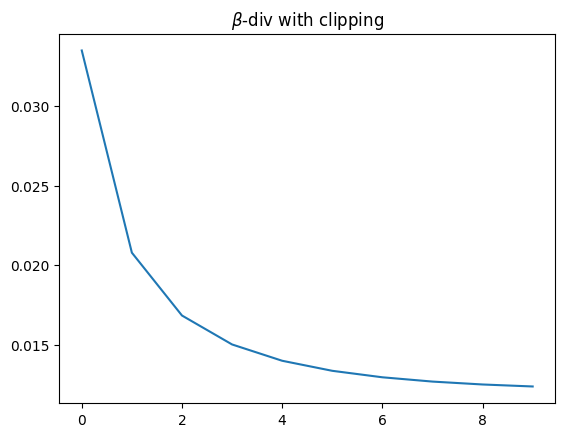

In [2]:
from torchbd.loss import *

W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
W, freqs, sample_rate, true_freqs = init.init_W(W_path, normalize_thresh=0.01)
y, sr = torchaudio.load("test-data/piano-dataset/audios/example-1.wav")
M, times, freqs_M = spec.cqt_spec(y, sr)
eps = torch.finfo().min
l = W.shape[1]
t = M.shape[1]
H = torch.rand(l, t)
H = torch.clamp(H, min=eps)
H = H.to(dev)

n_init_steps = 10
divs = []
beta_div = BetaDivLoss(beta=1, reduction='mean')

for _ in range(n_init_steps):
    
    Wh = W @ H
    Wh = torch.clamp(Wh, min=eps)
    Wh_beta_minus_2 = Wh ** (1 - 2)
    Wh_beta_minus_1 = Wh ** (1 - 1)
    Wt = W.T

    numerator = Wt @ (Wh_beta_minus_2 * M)
    denominator = Wt @ Wh_beta_minus_1
    denominator = torch.clamp(denominator, min=eps)
    H = H * (numerator / denominator)
    # H = torch.clamp(H, min=eps, max=min(1, H.max()))
    
    M_hat = W@H
    div = beta_div(M_hat, M)
    divs.append(div.cpu())
    
# H = torch.clamp(H, min=eps, max=min(1, H.max()))
plt.plot(divs)
plt.title(r'$\beta$-div with clipping')
divs[-1]

### Loading the models and visualizing the CNNs ($A_W$ and $A_H$) behavior

In [3]:
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
# model = "checkpoint"
model = "1e-2lr_clip_10%"
mu = models.MU_NMF(n_iter=10, W_path=W_path)
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, hidden=16, n_iter=10, n_init_steps=1, shared=False, return_layers=False, aw_2d=False, clip_H=False, dtype=None)
# ralmu = models.RALMU(l=88, beta=1, W_path=W_path, hidden=16, n_iter=10, n_init_steps=1, shared=True, return_layers=False, aw_2d=False, clip_H=False, dtype=None)
ralmu = ralmu.to(dev)
state_dict = torch.load(f'/home/ids/edabier/AMT/Unrolled-NMF/models/{model}.pt', map_location=dev)
ralmu.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

W mean: 3.605722188949585, std: 0.5204530954360962, H mean: 0.7222883105278015, std: 0.28643184900283813
W mean: 0.782740592956543, std: 0.016271505504846573, H mean: 0.6928995251655579, std: 0.0013279829872772098
W mean: 0.7745245695114136, std: 0.006108875386416912, H mean: 0.6928030252456665, std: 8.29341388453031e-06
W mean: 0.797942042350769, std: 0.0009668992133811116, H mean: 0.6930448412895203, std: 5.3047297114972025e-05
W mean: 0.822047233581543, std: 0.0004975915653631091, H mean: 0.6929120421409607, std: 0.0018795635551214218
W mean: 0.844719648361206, std: 0.040399596095085144, H mean: 0.9114402532577515, std: 1.6535052061080933
W mean: 0.8814250826835632, std: 0.016725586727261543, H mean: 0.6937298774719238, std: 0.0005435962229967117
W mean: 0.7246315479278564, std: 0.012240552343428135, H mean: 7.958193302154541, std: 1.1229199171066284
W mean: 3.325428009033203, std: 0.2502942681312561, H mean: 1.0533465147018433, std: 0.0527556836605072
W mean: 0.8018225431442261, st

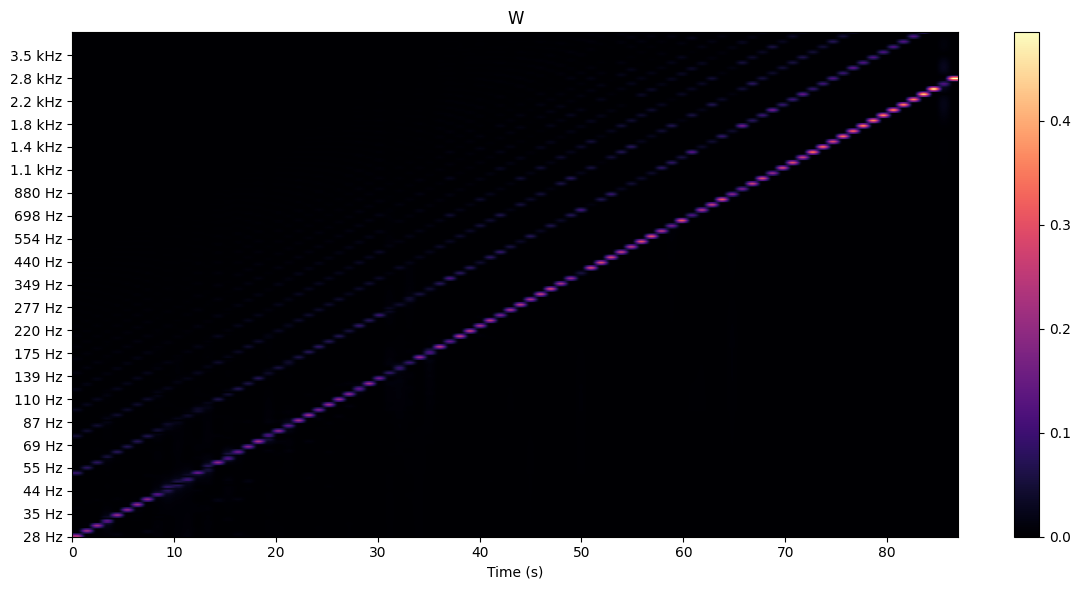

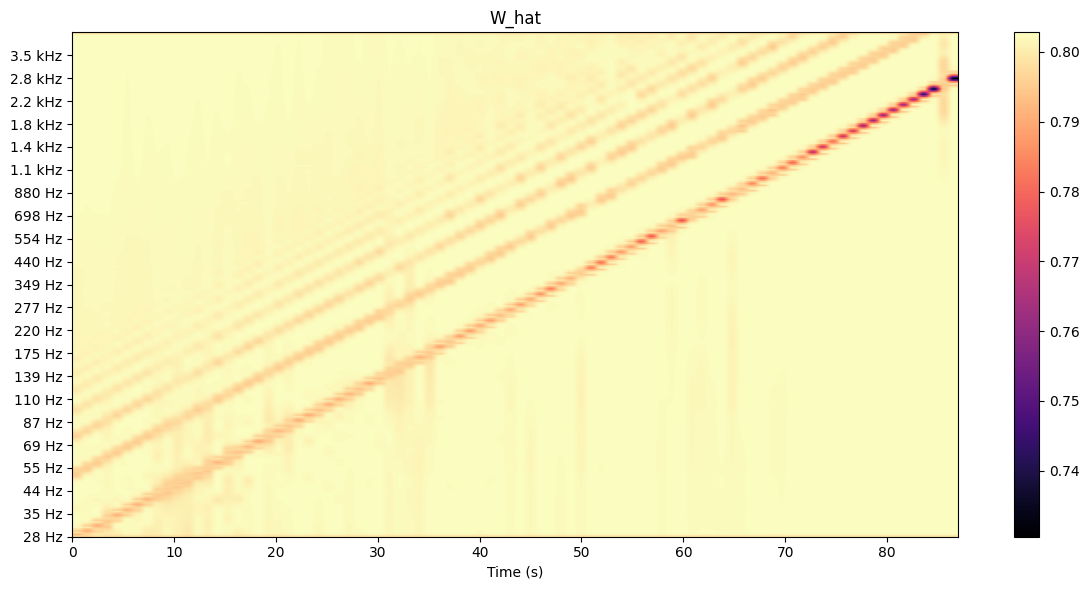

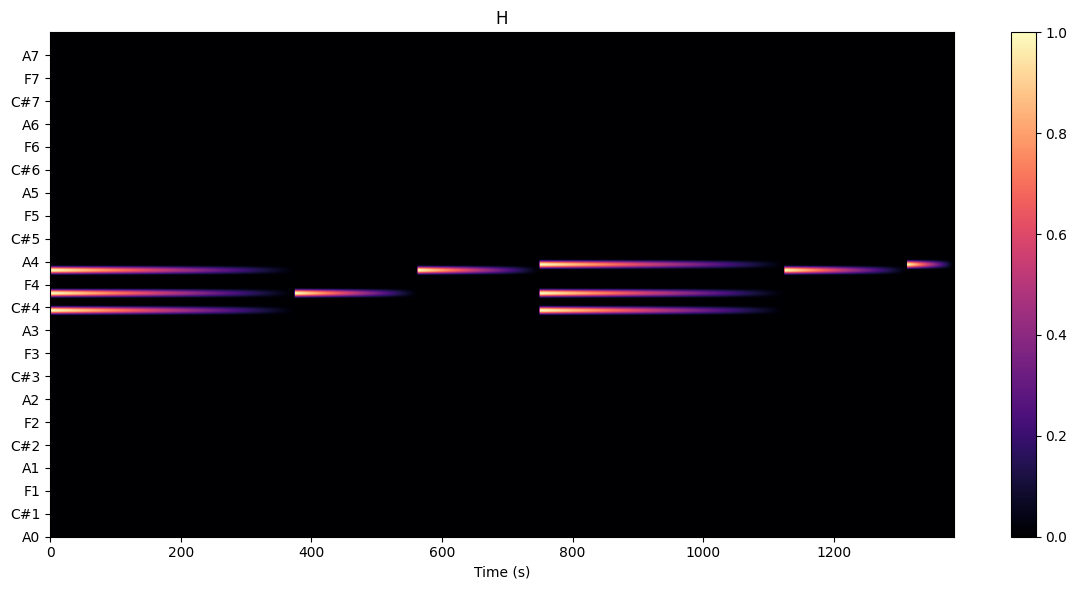

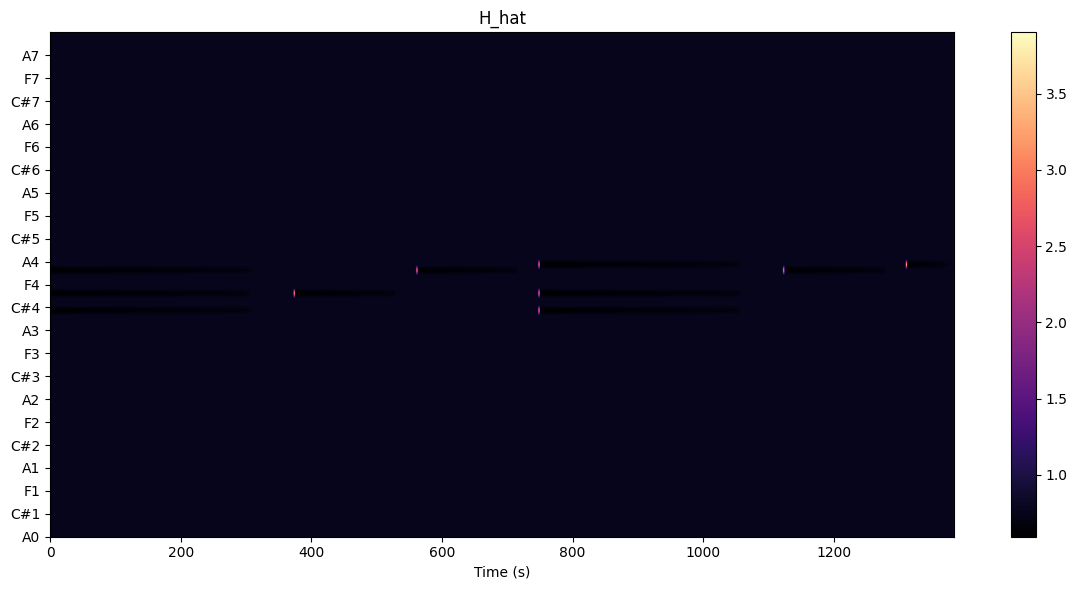

In [4]:
batch_size=1

W, freqs, sample_rate, true_freqs = init.init_W(W_path, normalize_thresh=0.01)
W = W.unsqueeze(0)
y, sr = torchaudio.load("test-data/piano-dataset/audios/example-1.wav")
M, times, freqs_M = spec.cqt_spec(y, sr)
midi, onset, offset, _ = spec.midi_to_pianoroll(f"test-data/piano-dataset/midis/example-1.mid", y, times, hop_length=128, sr=sr)
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset, values_range=1)
H = H.unsqueeze(0)
W = W.to(dev)
H = H.to(dev)
H_rows = [H[:, i:i+1, :] for i in range(0, 88)]

for i in range(10):
    Aw = ralmu.layers[i].Aw
    Ah = ralmu.layers[i].Ah
    W_hat = torch.cat([Aw(W[:, :, i]) for i in range(88)], 2)
    H_hat = torch.cat([Ah(H_i) for H_i in H_rows], 1)
    print(f"W mean: {W_hat[0].mean()}, std: {W_hat[0].std()}, H mean: {H_hat[0].mean()}, std: {H_hat[0].std()}")

for i in range(len(freqs)):
    freqs[i] = freqs[i].detach().cpu()

spec.vis_cqt_spectrogram(W[0].detach().cpu(), frequencies=freqs, title="W")
spec.vis_cqt_spectrogram(W_hat[0].detach().cpu(), frequencies=freqs, title="W_hat")
spec.vis_cqt_spectrogram(H[0].detach().cpu(), frequencies=freqs, set_note_label=True, title="H")
spec.vis_cqt_spectrogram(H_hat[0].detach().cpu(), frequencies=freqs, set_note_label=True, title="H_hat")

### Comparing MU and RALMU on the <ins>**train**</ins> dataset

Split the dataset - done ✓


0it [00:00, ?it/s]

16it [00:00, 19.11it/s]
/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()


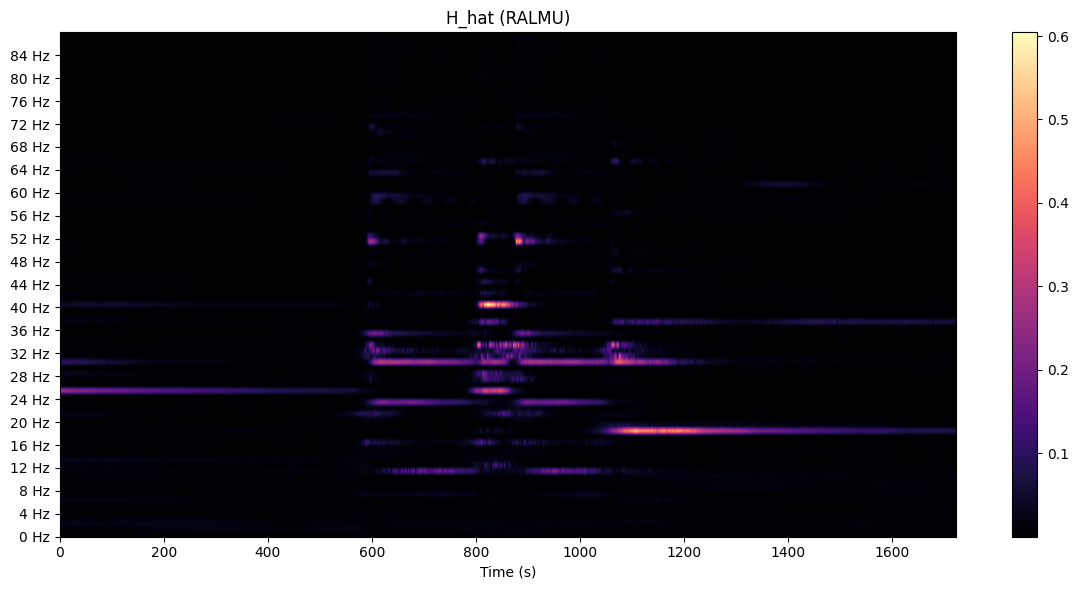

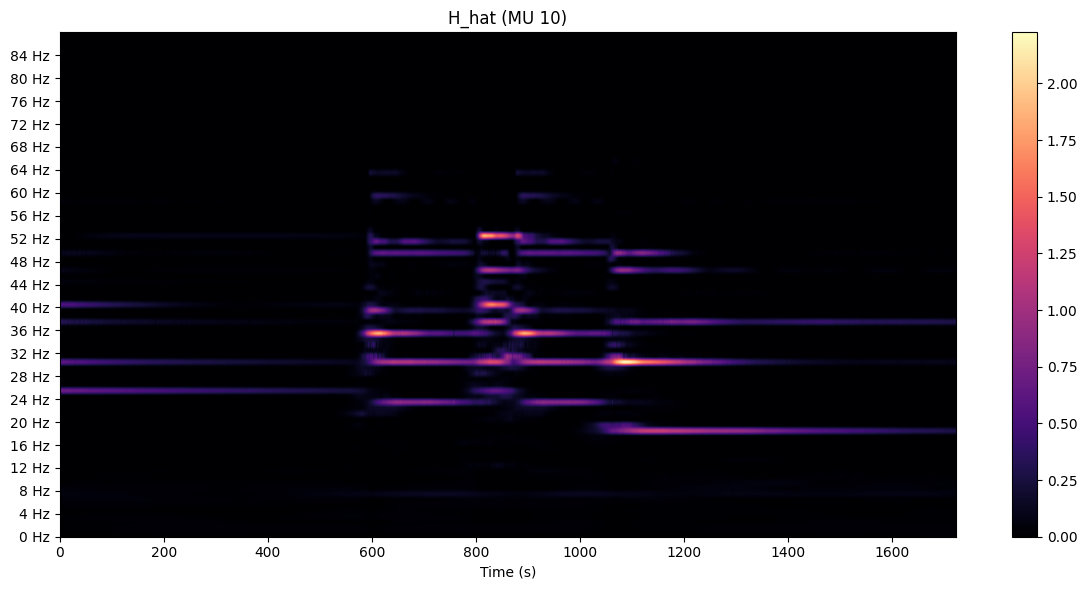

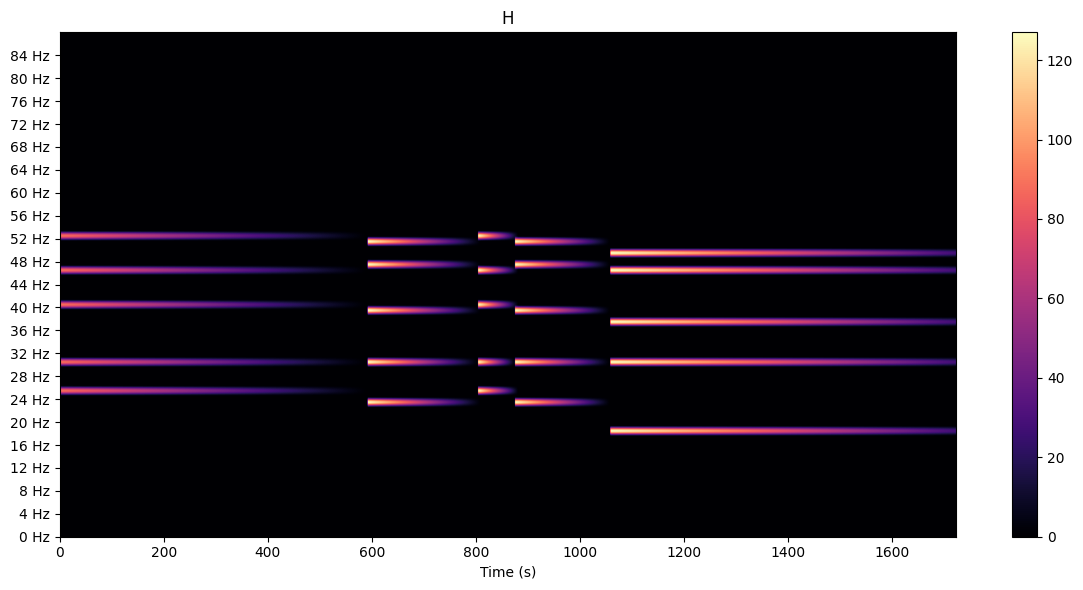

In [5]:
split=0.8
subset=0.1
length = 10
dtype = None
eps=1e-6
path = "/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv"

metadata = pd.read_csv(path)
train_data, test_data   = train_test_split(metadata, train_size=split, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=split, random_state=1)
train_data = train_data.reset_index(drop=True)
print("Split the dataset - done ✓")

train_set   = utils.LocalDataset(train_data, use_midi=True, fixed_length=length, subset=subset, dtype=dtype)
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=1)
collate_fn = utils.create_collate_fn(use_midi=True)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate_fn)

for i, (M, H, midi) in enumerate(train_loader):
    if i == 0:
        continue
    elif i==1:
        with torch.no_grad():
            M = torch.clamp(M, min=eps)
            M = M.squeeze(0)
            M = M.to(dev)
            H = H.squeeze(0)
            H = H.to(dev)
            midi = midi.squeeze(0)
            midi = midi.to(dev)
            M = M/torch.max(M)
            H_norm, norm = spec.l1_norm(H, threshold=0.01)
            
            W_hat_ralmu, H_hat_ralmu, M_hat_ralmu = ralmu.forward(M, device=dev)
            
            W_hat_mu, H_hat_mu, M_hat_mu = mu.forward(M, device=dev)
    break

spec.vis_cqt_spectrogram(H_hat_ralmu.detach().cpu(), title="H_hat (RALMU)")
spec.vis_cqt_spectrogram(H_hat_mu.detach().cpu(), title="H_hat (MU 10)")
spec.vis_cqt_spectrogram(H.detach().cpu(), title="H")

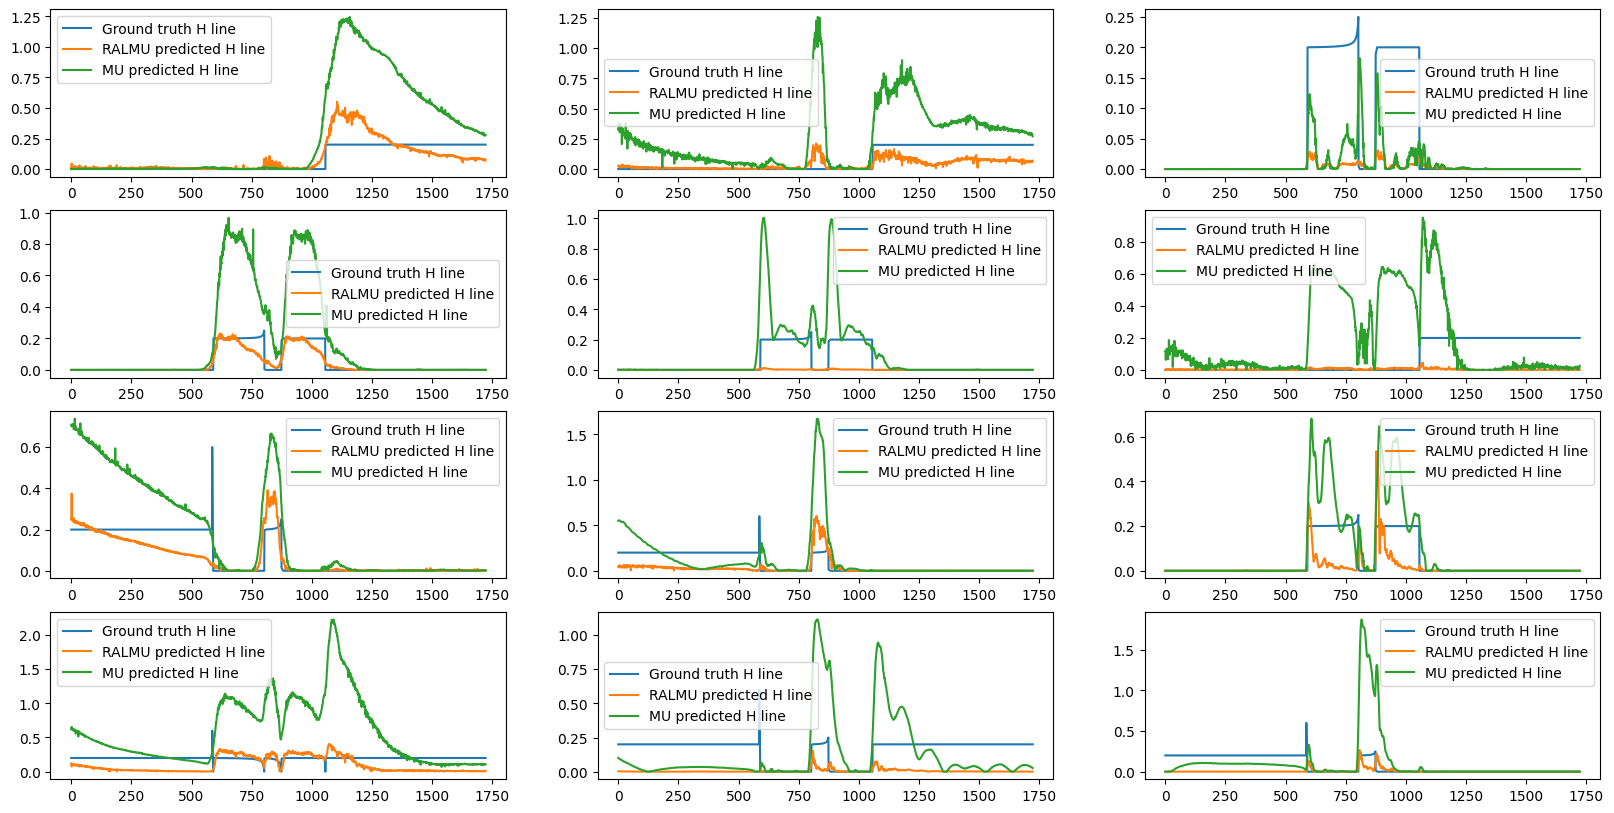

In [6]:
fig, axs = plt.subplots(4,3, figsize=(20,10))

active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]

axs[0,0].plot(H_norm[active_midi[0]].detach().cpu(), label="Ground truth H line")
axs[0,0].plot(H_hat_ralmu[active_midi[0]].detach().cpu(), label="RALMU predicted H line")
axs[0,0].plot(H_hat_mu[active_midi[0]].detach().cpu(), label="MU predicted H line")
axs[0,0].legend()

axs[1,0].plot(H_norm[active_midi[1]].detach().cpu(), label="Ground truth H line")
axs[1,0].plot(H_hat_ralmu[active_midi[1]].detach().cpu(), label="RALMU predicted H line")
axs[1,0].plot(H_hat_mu[active_midi[1]].detach().cpu(), label="MU predicted H line")
axs[1,0].legend()

axs[2,0].plot(H_norm[active_midi[2]].detach().cpu(), label="Ground truth H line")
axs[2,0].plot(H_hat_ralmu[active_midi[2]].detach().cpu(), label="RALMU predicted H line")
axs[2,0].plot(H_hat_mu[active_midi[2]].detach().cpu(), label="MU predicted H line")
axs[2,0].legend()

axs[3,0].plot(H_norm[active_midi[3]].detach().cpu(), label="Ground truth H line")
axs[3,0].plot(H_hat_ralmu[active_midi[3]].detach().cpu(), label="RALMU predicted H line")
axs[3,0].plot(H_hat_mu[active_midi[3]].detach().cpu(), label="MU predicted H line")
axs[3,0].legend()

axs[0,1].plot(H_norm[active_midi[4]].detach().cpu(), label="Ground truth H line")
axs[0,1].plot(H_hat_ralmu[active_midi[4]].detach().cpu(), label="RALMU predicted H line")
axs[0,1].plot(H_hat_mu[active_midi[4]].detach().cpu(), label="MU predicted H line")
axs[0,1].legend()

axs[1,1].plot(H_norm[active_midi[5]].detach().cpu(), label="Ground truth H line")
axs[1,1].plot(H_hat_ralmu[active_midi[5]].detach().cpu(), label="RALMU predicted H line")
axs[1,1].plot(H_hat_mu[active_midi[5]].detach().cpu(), label="MU predicted H line")
axs[1,1].legend()

axs[2,1].plot(H_norm[active_midi[6]].detach().cpu(), label="Ground truth H line")
axs[2,1].plot(H_hat_ralmu[active_midi[6]].detach().cpu(), label="RALMU predicted H line")
axs[2,1].plot(H_hat_mu[active_midi[6]].detach().cpu(), label="MU predicted H line")
axs[2,1].legend()

axs[3,1].plot(H_norm[active_midi[7]].detach().cpu(), label="Ground truth H line")
axs[3,1].plot(H_hat_ralmu[active_midi[7]].detach().cpu(), label="RALMU predicted H line")
axs[3,1].plot(H_hat_mu[active_midi[7]].detach().cpu(), label="MU predicted H line")
axs[3,1].legend()

axs[0,2].plot(H_norm[active_midi[8]].detach().cpu(), label="Ground truth H line")
axs[0,2].plot(H_hat_ralmu[active_midi[8]].detach().cpu(), label="RALMU predicted H line")
axs[0,2].plot(H_hat_mu[active_midi[8]].detach().cpu(), label="MU predicted H line")
axs[0,2].legend()

axs[1,2].plot(H_norm[active_midi[9]].detach().cpu(), label="Ground truth H line")
axs[1,2].plot(H_hat_ralmu[active_midi[9]].detach().cpu(), label="RALMU predicted H line")
axs[1,2].plot(H_hat_mu[active_midi[9]].detach().cpu(), label="MU predicted H line")
axs[1,2].legend()

axs[2,2].plot(H_norm[active_midi[10]].detach().cpu(), label="Ground truth H line")
axs[2,2].plot(H_hat_ralmu[active_midi[10]].detach().cpu(), label="RALMU predicted H line")
axs[2,2].plot(H_hat_mu[active_midi[10]].detach().cpu(), label="MU predicted H line")
axs[2,2].legend()

axs[3,2].plot(H_norm[active_midi[11]].detach().cpu(), label="Ground truth H line")
axs[3,2].plot(H_hat_ralmu[active_midi[11]].detach().cpu(), label="RALMU predicted H line")
axs[3,2].plot(H_hat_mu[active_midi[11]].detach().cpu(), label="MU predicted H line")
axs[3,2].legend()

In [ ]:
_, notes_hat_ralmu = init.W_to_pitch(W_hat_ralmu.cpu(), true_freqs=None, use_max=True)
_, notes_hat_mu = init.W_to_pitch(W_hat_mu.cpu(), true_freqs=None, use_max=True)

best_f_ralmu = 0
best_thresh_ralmu = 0
best_f_mu = 0
best_thresh_ralmu = 0

threshs = torch.linspace(0.01, 10, 100)

for thresh in threshs:
    midi_hat_ralmu, _ = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=30, sr=44100)
    _, _, f_mes_ralmu, _ = utils.compute_metrics(midi_hat_ralmu[active_midi[:12]], midi[active_midi[:12]], time_tolerance=200)
    
    midi_hat_mu, _ = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=30, sr=44100)
    _, _, f_mes_mu, _ = utils.compute_metrics(midi_hat_mu[active_midi[:12]], midi[active_midi[:12]], time_tolerance=200)

    if f_mes_ralmu > best_f_ralmu:
        best_thresh_ralmu = thresh
        best_f_ralmu = f_mes_ralmu
        
    if f_mes_mu > best_f_mu:
        best_thresh_mu = thresh
        best_f_mu = f_mes_mu

midi_hat_ralmu, _ = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=best_thresh_ralmu, smoothing_window=10, min_note_length=30, sr=44100)
midi_hat_mu, _ = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=best_thresh_mu, smoothing_window=10, min_note_length=30, sr=44100)
spec.compare_midi(midi[active_midi[:12]].cpu(), midi_hat_ralmu[active_midi[:12]].cpu())
spec.compare_midi(midi[active_midi[:12]].cpu(), midi_hat_mu[active_midi[:12]].cpu())

prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi_hat_ralmu[active_midi[:12]], midi[active_midi[:12]], time_tolerance=200)
print("Metrics for RALMU prediction: ", prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu)

prec_mu, rec_mu, f_mes_mu, accuracy_mu = utils.compute_metrics(midi_hat_mu[active_midi[:12]], midi[active_midi[:12]], time_tolerance=200)
print("Metrics for MU prediction: ", prec_mu, rec_mu, f_mes_mu, accuracy_mu)
# spec.pianoroll_to_midi(midi_hat, "/home/ids/edabier/AMT/Unrolled-NMF/ralmu_midi_pred.mid", times)

[1055, 1310, 1723] 18
[595, 1050, 1723] 23
[375, 795, 865, 1723] 25
[600, 1195, 1723] 30
[800, 905, 1723] 33
[805, 880, 1723] 40


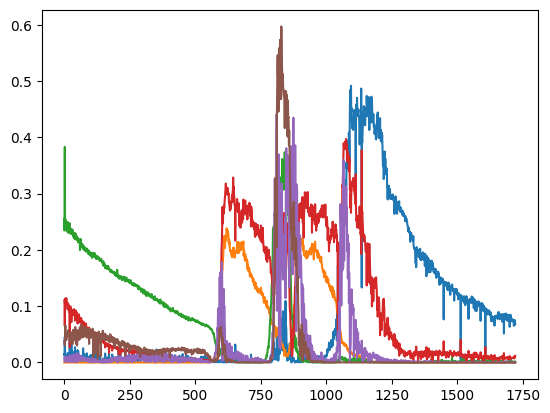

In [7]:
import ruptures as rpt

for i in range(H_hat_ralmu.shape[0]):
    y = H_hat_ralmu[i].detach().cpu()
    algo = rpt.Pelt().fit(y)
    bkps = algo.predict(pen=2.0)
    
    if len(bkps) > 1:
        print(bkps, i)
        plt.plot(y)
        plt.show()
    else:
        if bkps[0] != 1723:
            print(bkps)

In [10]:
for i in range(H.shape[0]):
    y = H[i].detach().cpu()
    algo = rpt.Pelt().fit(y)
    bkps = algo.predict(pen=2.0)
    
    if len(bkps) > 1:
        print(i)
        # plt.plot(y)
        # plt.show()
    else:
        if bkps[0] != 1723:
            print(bkps)

18
23
25
30
37
39
40
46
47
49
51
52
